In [8]:
#!/usr/bin/env python

# ClimatologicalAnalysis.ipynb

In [1]:
''' 
   ClimatologicalAnalysis.ipynb

   This program reads in netcdf output from previously running 
   papers/2021_Object-Tracker-Intro/programs/Global_ProcessIdentification.ipynb
   
   It reads in atmospheric variables and identified objects and plots climatological analysis.

'''

' \n   ClimatologicalAnalysis.ipynb\n\n   This program reads in netcdf output from previously running \n   papers/2021_Object-Tracker-Intro/programs/Global_ProcessIdentification.ipynb\n   \n   It reads in atmospheric variables and identified objects and plots climatological analysis.\n\n'

In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import glob
import os
from pdb import set_trace as stop
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import median_filter
from scipy.ndimage import label
from matplotlib import cm
from scipy import ndimage
import random
import scipy
import pickle
import datetime
import pandas as pd
import subprocess
import matplotlib.path as mplPath
import sys
from calendar import monthrange

#### speed up interpolation
import scipy.interpolate as spint
import scipy.spatial.qhull as qhull
import numpy as np
#import h5py
import xarray as xr
import netCDF4

# from mpl_toolkits.basemap import Basemap, cm
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from pylab import *
import string
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import shapefile
from tqdm import tqdm

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import shapely.geometry as sgeom

from Tracking_Functions import ObjectCharacteristics

###  USER MODIFY SECTION

In [3]:
DataFolder = '/glade/campaign/mmm/c3we/prein/Papers/2021_Object-Tracker-Intro/data/OPTIMIZE_4/'
sPlotFile = '/glade/campaign/mmm/c3we/prein/Papers/2021_Object-Tracker-Intro/plots/ClimatologicalAnalysis/'

dT = 1  # temporal resolution in hours

StartDay = datetime.datetime(2001, 1, 1, 0) 
StopDay = datetime.datetime(2020, 12, 31, 23)
# StopDay = datetime.datetime(2002, 12, 31, 23)
Time = pd.date_range(StartDay, end=StopDay, freq=str(dT)+'h')
TimeMM = pd.date_range(StartDay, end=StopDay, freq='m')
Years = np.unique(Time.year)


# precipitation tracking options
SmoothSigmaP = 1  # Gaussion std for precipitation smoothing
Pthreshold = 2.5    # precipitation threshold [mm/h]
# minimum AR volume
MinTimeAR = 3 # in 3-hours
MinVolAR = MinTimeAR*10*10 # hours x lon x lat grid cells
# minimum cyclone volume
MinTimeCY = 6 # minimum livetime in hours
# minimum frontal zone area
MinArea = 10*10 # lon x lat grid cells
# cloud tracking setup
SmoothSigmaC = 1
Cthreshold = 241
MinTimeC = 3 # in 3-hours
MinVolC = MinTimeC*10*10 # hours x lon x lat grid cells
# AR tracking
IVTtrheshold = 500 # [kg m-1 s-1]
MinTimeIVT = 3

### Read in the Grid

In [4]:
ncid=Dataset('/glade/campaign/mmm/c3we/prein/Papers/2021_Object-Tracker-Intro/data/OPTIMIZE_2/201309_ERA5_ObjectMasks_dt-1h_PRTr-2_PRS-1_ARt-9_ARL-2000_CYt-12_FRA-50000_CLS-1_CLT-241_CLt-9_CLA-40000_IVTTr-500_IVTt-9.nc')
Lat=np.squeeze(ncid.variables['lat'][:])
Lon=np.squeeze(ncid.variables['lon'][:])
ncid.close()

In [5]:
EarthCircum = 40075000 #[m]
dLat = np.copy(Lon); dLat[:] = EarthCircum/(Lat.shape[0]*2)
dLon = np.copy(Lon)
for la in range(Lat.shape[0]):
    dLon[la,:] = EarthCircum/(Lat.shape[0]*2)*np.cos(np.deg2rad(Lat[la,0]))
Area = dLat*dLon

# get average distance betwenn grid cells
Lat_mean=np.mean(Lat)
Lon_mean=np.mean(Lon)
dLat_mean = np.mean(Lat[1:,:]-Lat[:-1,:])
dLon_mean = np.mean(Lon[:,1:]-Lon[:,:-1])

# Gridspacing=haversine(Lon_mean, dLat_mean, Lon_mean+dLon_mean, dLat_mean+dLat_mean)*1000. #  horizontal grid spacing in m
Gridspacing = np.mean(np.append(dLat[:,:,None],dLon[:,:,None], axis=2))

### Read the netCDF file

In [6]:
CYCLONES = {}
TCOBJ = {}
ANTICYCLONES = {}
AROBJ = {}
MCSOBJ = {}

Objects = ['Cyclones','Anticyclones','MCSs','TCs','Fronts','ARs'] 
MonthlyObjectFrequency = np.zeros((len(TimeMM), Lon.shape[0],Lon.shape[1],len(Objects))); MonthlyObjectFrequency[:] = np.nan

for mm in tqdm(range(len(TimeMM))):
    YYYY = str(TimeMM[mm].year)
    MM = str(TimeMM[mm].month).zfill(2)
    
    # save processed data for each month
    save_data_mon_dir = DataFolder+'montly_feature_frequ_v1/'
    if not os.path.exists(save_data_mon_dir):
        os.makedirs(save_data_mon_dir)

    save_data_mon_file = save_data_mon_dir + YYYY+MM+'_montly_feature_frequ.npz'
    if not os.path.exists(save_data_mon_file):
        InputFile = YYYY+MM+'_ERA5_ObjectMasks_dt-1h_PRTr-2_PRS-0_ARt-9_ARL-2000_CYt-12_FRA-50000_CLS-0_CLT-241_CLt-4_CLA-40000_IVTTr-500_IVTt-9.nc'
        print('    Reading: '+InputFile)
        
        ncid=Dataset(DataFolder+InputFile, mode='r')
        Lat=np.squeeze(ncid.variables['lat'][:])
        Lon=np.squeeze(ncid.variables['lon'][:])
        PR = np.squeeze(ncid.variables['PR'])
#         PR_obj = np.squeeze(ncid.variables['PR_Objects'])
#         Cloud = np.squeeze(ncid.variables['MCS'])
        MCS_obj = np.squeeze(ncid.variables['MCS_Objects'])
#         Fronts = np.squeeze(ncid.variables['FR'])
        FR_obj = np.squeeze(ncid.variables['FR_Objects'])
#         CY = np.squeeze(ncid.variables['CY'])
        CY_obj = np.squeeze(ncid.variables['CY_Objects'])
        ACY_obj = np.squeeze(ncid.variables['ACY_Objects'])
#         AR = np.squeeze(ncid.variables['MS'])
        AR_obj = np.squeeze(ncid.variables['MS_Objects'])
#         IVT = np.squeeze(ncid.variables['IVT'])
        AR_obj = np.squeeze(ncid.variables['AR_Objects'])
        TC_obj = np.squeeze(ncid.variables['TC_Objects'])
#         T_real = np.squeeze(ncid.variables['T850'])
        ncid.close()

        ### Load tracked objects
        grCyclonesPT = np.load(DataFolder+'CY_'+InputFile.split('_')[0]+'_ERA5'+InputFile.split('ObjectMasks')[1][1:-3], allow_pickle=True)
        grACyclonesPT = np.load(DataFolder+'ACY_'+InputFile.split('_')[0]+'_ERA5'+InputFile.split('ObjectMasks')[1][1:-3], allow_pickle=True)
        grMCSobjects = np.load(DataFolder+'MCSs_'+InputFile.split('_')[0]+'_ERA5'+InputFile.split('ObjectMasks')[1][1:-3], allow_pickle=True)
        grARobjects = np.load(DataFolder+'ARs_'+InputFile.split('_')[0]+'_ERA5'+InputFile.split('ObjectMasks')[1][1:-3], allow_pickle=True)
        grTCobjects = np.load(DataFolder+'TC_'+InputFile.split('_')[0]+'_ERA5'+InputFile.split('ObjectMasks')[1][1:-3], allow_pickle=True)

        # Collect the tracked object
        CYCLONES[YYYY+MM] = grCyclonesPT
        ANTICYCLONES[YYYY+MM] = grACyclonesPT
        MCSOBJ[YYYY+MM] = grMCSobjects
        AROBJ[YYYY+MM] = grARobjects
        TCOBJ[YYYY+MM] = grTCobjects
        
        mean_cy = np.mean(CY_obj >0, axis=0)
        mean_acy = np.mean(ACY_obj >0, axis=0)
        mean_tc = np.mean(TC_obj >0, axis=0)
        mean_mcs = np.mean(MCS_obj >0, axis=0)
        mean_fr = np.mean(FR_obj >0, axis=0)
        mean_ar = np.mean(AR_obj >0, axis=0)
        
        np.savez(save_data_mon_file,
                mean_cy = mean_cy,
                mean_acy = mean_acy,
                mean_mcs = mean_mcs,
                mean_tc = mean_tc,
                mean_fr = mean_fr,
                mean_ar = mean_ar)
    else:
        DATA = np.load(save_data_mon_file)
        mean_cy = DATA['mean_cy']
        mean_acy = DATA['mean_acy']
        mean_mcs = DATA['mean_mcs']
        mean_tc = DATA['mean_tc']
        mean_fr = DATA['mean_fr']
        mean_ar = DATA['mean_ar']

    # Collect the monthly frequency of objects
    MonthlyObjectFrequency[mm,:,:,Objects.index('Cyclones')] = mean_cy
    MonthlyObjectFrequency[mm,:,:,Objects.index('Anticyclones')] = mean_acy
    MonthlyObjectFrequency[mm,:,:,Objects.index('MCSs')] = mean_mcs
    MonthlyObjectFrequency[mm,:,:,Objects.index('TCs')] = mean_tc
    MonthlyObjectFrequency[mm,:,:,Objects.index('Fronts')] = mean_fr
    MonthlyObjectFrequency[mm,:,:,Objects.index('ARs')] = mean_ar


100%|██████████| 240/240 [00:48<00:00,  4.94it/s]


### PLOT GLOBAL MAP - ANNUAL FREQUENCIES AND PEAK MONTH

In [10]:
print(MonthlyObjectFrequency.shape)

(240, 721, 1440, 6)


aa
0


/glade/scratch/mingge/ipykernel_300860/1207975887.py:80: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = colorbar(cs, cax = CbarAx, orientation='vertical', extend='max') #, ticks=clevs),
/glade/work/mingge/miniconda3/envs/casper_2020/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


1
2
3
4
5
        Plot map to: /glade/campaign/mmm/c3we/prein/Papers/2021_Object-Tracker-Intro/plots/ClimatologicalAnalysis/Annual_feature_frequencies_peak-month.jpg


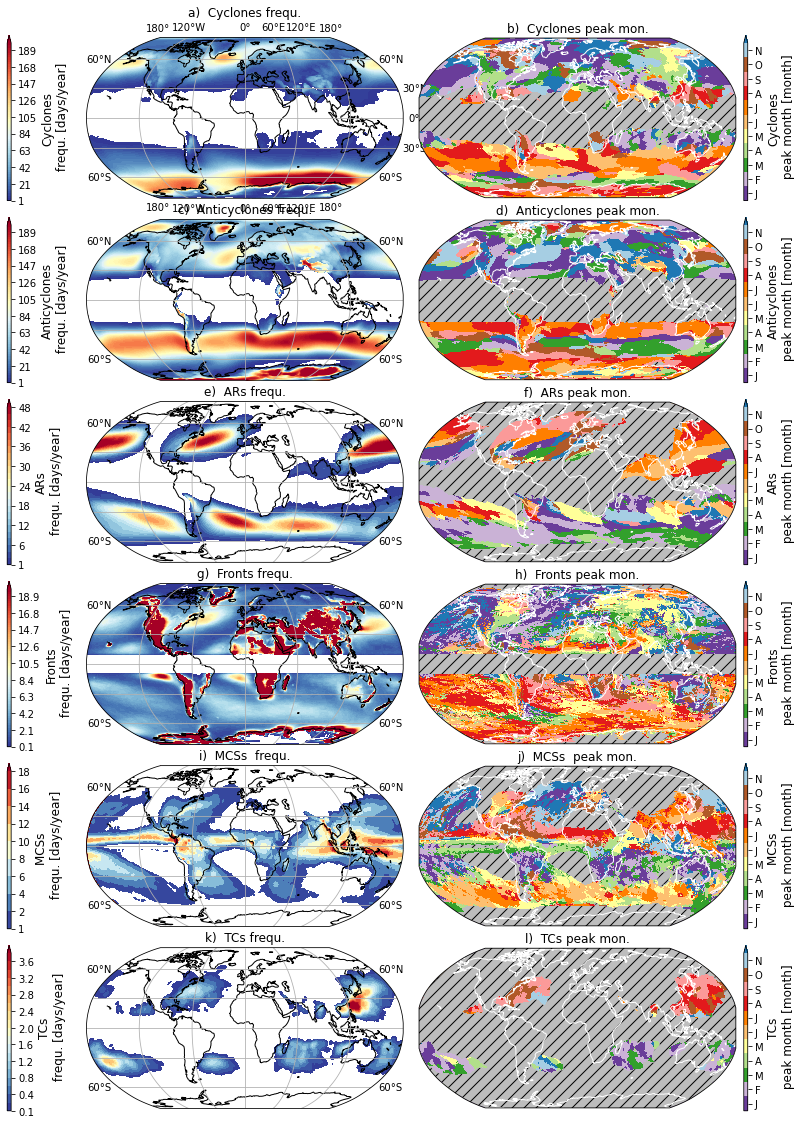

In [8]:
from scipy.ndimage import gaussian_filter
import matplotlib.gridspec as gridspec
# from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from pylab import *
import string
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import shapefile
from matplotlib import colors as c

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import shapely.geometry as sgeom
from matplotlib.colors import LogNorm
 
fig = plt.figure(figsize=(11,18))
rgsLableABC=list(string.ascii_lowercase)
gs1 = gridspec.GridSpec(len(Objects),2)
gs1.update(left=0.14, right=0.96,
   bottom=0.10, top=0.93,
   wspace=0.05, hspace=0.1)

ObjectsSort = ['Cyclones','Anticyclones','ARs','Fronts','MCSs','TCs'] 
for st in range(len(Objects)):
    print(st)
    if ObjectsSort[st] == 'Cyclones':
        DATA = MonthlyObjectFrequency[:,:,:,Objects.index('Cyclones')]
        Levels = np.arange(0,200,3)
        MIN = 1
        Label = 'Cyclones'
    elif ObjectsSort[st] == 'Anticyclones':
        DATA = MonthlyObjectFrequency[:,:,:,Objects.index('Anticyclones')]
        Levels = np.arange(0,200,3)
        MIN = 1
        Label = 'Anticyclones'
    elif ObjectsSort[st] == 'ARs':
        DATA = MonthlyObjectFrequency[:,:,:,Objects.index('ARs')]
        Levels = np.arange(0,50,2)
        MIN = 1
        Label = 'ARs'
    elif ObjectsSort[st] == 'Fronts':
        DATA = MonthlyObjectFrequency[:,:,:,Objects.index('Fronts')]
        Levels = np.arange(0,20,0.3)
        MIN = 0.1
        Label = 'Fronts'
    elif ObjectsSort[st] == 'MCSs':
        DATA = MonthlyObjectFrequency[:,:,:,Objects.index('MCSs')]
        Levels = np.arange(0,20,2)
        MIN = 1
        Label = 'MCSs '
    elif ObjectsSort[st] == 'TCs':
        DATA = MonthlyObjectFrequency[:,:,:,Objects.index('TCs')]
        Levels = np.arange(0,4,0.2)
        MIN = 0.1
        Label = 'TCs'
    Levels[0] = MIN

    DATAse = np.nanmean(DATA[:,:,:], axis = 0)*365.25
    DATAse[DATAse < MIN] = np.nan

    proj = ccrs.Robinson() 
    ax = plt.subplot(gs1[st,0], projection=proj)
    pos1 = ax.get_position()
    cs = plt.contourf(Lon,Lat,DATAse, transform=ccrs.PlateCarree(), levels=Levels, extend='max', cmap='RdYlBu_r')#, cmap='hot_r')
    plt.title(rgsLableABC[0+st*2]+') '+' '+Label+' frequ.')

    ax.coastlines()
    if (st == 0):
        gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
        gl.left_labels = False
    else:
        gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
        gl.top_labels = gl.right_labels = gl.left_labels = gl.bottom_labels = False

    CbarAx = axes([0.04, pos1.y0, 0.005, pos1.height])
    cb = colorbar(cs, cax = CbarAx, orientation='vertical', extend='max') #, ticks=clevs), 
    cb.set_label(Label+'\n frequ. [days/year]', fontsize=12)
    
    
    # =============================================================
    # =============================================================
    # Plot peak month
    ax = plt.subplot(gs1[st,1], projection=proj)
    peak_mon_color = ['#6a3d9a','#cab2d6','#33a02c','#b2df8a','#ffff99','#fdbf6f','#ff7f00','#e31a1c','#fb9a99','#b15928','#a6cee3','#1f78b4','#1f78b4']
    cMap = c.ListedColormap(peak_mon_color)
    DATAse = np.nanmean(DATA[:,:,:], axis = 0)*365.25
    DATAse[DATAse < 0.25] = np.nan
    peak_month = np.argmax(np.mean(np.reshape(DATA, (int(DATA.shape[0]/12), 12, DATA.shape[1], DATA.shape[2])), axis=0), axis=0)

    cs = plt.pcolormesh(Lon, Lat, peak_month, cmap=cMap, 
                    norm = mpl.colors.BoundaryNorm(np.array(range(12)), ncolors=len(np.array(range(12)))-1, clip=False),
                    transform=ccrs.PlateCarree())

#     cs = plt.contourf(Lon, Lat, peak_month, levels=np.array(range(12)), cmap='twilight_shifted', transform=ccrs.PlateCarree())
    gray_background = np.array(DATAse > 0.25).astype('float')
    gray_background[gray_background == 1] = np.nan
    plt.contourf(Lon, Lat, gray_background, colors=['#bdbdbd','k'],  levels = [0,0.9,1.1],alpha=1, transform=ccrs.PlateCarree())
    plt.contourf(Lon, Lat, gray_background, hatches=['//',''],  levels = [0,0.9,1.1],alpha=0, transform=ccrs.PlateCarree())
    ax.set_extent([-180, 180, -85, 85], crs=ccrs.PlateCarree())
    
    ax.coastlines(color='w')
    plt.title(rgsLableABC[1+st*2]+') '+' '+Label+' peak mon.')

    CbarAx = axes([0.97, pos1.y0, 0.005, pos1.height])
    cb = colorbar(cs, cax = CbarAx, orientation='vertical', extend='max') #, ticks=clevs), 
    cb.set_ticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5])
    cb.set_ticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
    cb.set_label(Label+'\n peak month [month]', fontsize=12)
    
sPlotFile=sPlotFile
sPlotName= 'Annual_feature_frequencies_peak-month.jpg'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print('        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName, bbox_inches='tight')


#### zoom in AU (5S, 45S) (100E-165E)

In [45]:
i_s = 380
i_e = 542
j_s = 1120
j_e = 1385
print(np.amin(Lat[i_s:i_e, j_s:j_e]), np.amax(Lat[i_s:i_e, j_s:j_e]))
print(np.amin(Lon[i_s:i_e, j_s:j_e]), np.amax(Lon[i_s:i_e, j_s:j_e]))

-45.25 -5.0
100.0 166.0


0


/glade/scratch/mingge/ipykernel_300860/1577242495.py:63: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = colorbar(cs, cax = CbarAx, orientation='vertical', extend='max') #, ticks=clevs),


1
2
3
4
5
        Plot map to: /glade/campaign/mmm/c3we/prein/Papers/2021_Object-Tracker-Intro/plots/ClimatologicalAnalysis/Annual_feature_frequencies_peak-month_au.jpg


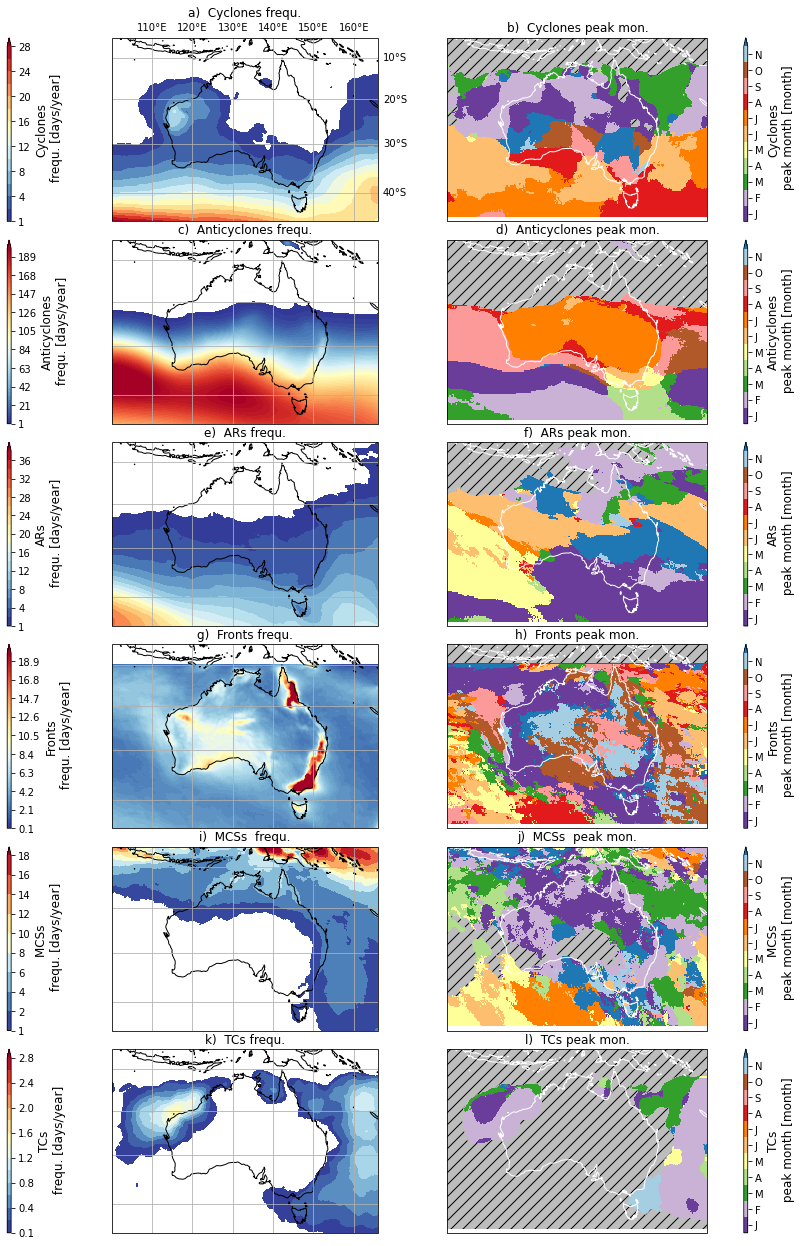

In [63]:
fig = plt.figure(figsize=(11, 20))
rgsLableABC=list(string.ascii_lowercase)
gs1 = gridspec.GridSpec(len(Objects),2)
gs1.update(left=0.14, right=0.96,
   bottom=0.10, top=0.93,
   wspace=0.05, hspace=0.1)

ObjectsSort = ['Cyclones','Anticyclones','ARs','Fronts','MCSs','TCs'] 
for st in range(len(Objects)):
    print(st)
    if ObjectsSort[st] == 'Cyclones':
        DATA = MonthlyObjectFrequency[:,i_s:i_e, j_s:j_e,Objects.index('Cyclones')]
        Levels = np.arange(0,30,2)
        MIN = 1
        Label = 'Cyclones'
    elif ObjectsSort[st] == 'Anticyclones':
        DATA = MonthlyObjectFrequency[:,i_s:i_e, j_s:j_e,Objects.index('Anticyclones')]
        Levels = np.arange(0,200,3)
        MIN = 1
        Label = 'Anticyclones'
    elif ObjectsSort[st] == 'ARs':
        DATA = MonthlyObjectFrequency[:,i_s:i_e, j_s:j_e,Objects.index('ARs')]
        Levels = np.arange(0,40,2)
        MIN = 1
        Label = 'ARs'
    elif ObjectsSort[st] == 'Fronts':
        DATA = MonthlyObjectFrequency[:,i_s:i_e, j_s:j_e,Objects.index('Fronts')]
        Levels = np.arange(0,20,0.3)
        MIN = 0.1
        Label = 'Fronts'
    elif ObjectsSort[st] == 'MCSs':
        DATA = MonthlyObjectFrequency[:,i_s:i_e, j_s:j_e,Objects.index('MCSs')]
        Levels = np.arange(0,20,2)
        MIN = 1
        Label = 'MCSs '
    elif ObjectsSort[st] == 'TCs':
        DATA = MonthlyObjectFrequency[:,i_s:i_e, j_s:j_e,Objects.index('TCs')]
        Levels = np.arange(0,3,0.2)
        MIN = 0.1
        Label = 'TCs'
    Levels[0] = MIN

    DATAse = np.nanmean(DATA[:,:,:], axis = 0)*365.25
    DATAse[DATAse < MIN] = np.nan

    #proj = ccrs.Robinson() 
    proj = ccrs.Mercator()
    ax = plt.subplot(gs1[st,0], projection=proj)
    pos1 = ax.get_position()
    cs = plt.contourf(Lon[i_s:i_e, j_s:j_e],Lat[i_s:i_e, j_s:j_e],DATAse, transform=ccrs.PlateCarree(), levels=Levels, extend='max', cmap='RdYlBu_r')#, cmap='hot_r')
    plt.title(rgsLableABC[0+st*2]+') '+' '+Label+' frequ.')

    ax.coastlines()
    if (st == 0):
        gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
        gl.left_labels = False
        gl.bottom_labels = False
    else:
        gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
        gl.top_labels = gl.right_labels = gl.left_labels = gl.bottom_labels = False

    CbarAx = axes([0.04, pos1.y0, 0.005, pos1.height])
    cb = colorbar(cs, cax = CbarAx, orientation='vertical', extend='max') #, ticks=clevs), 
    cb.set_label(Label+'\n frequ. [days/year]', fontsize=12)
    
    
    # =============================================================
    # =============================================================
    # Plot peak month
    ax = plt.subplot(gs1[st,1], projection=proj)
    peak_mon_color = ['#6a3d9a','#cab2d6','#33a02c','#b2df8a','#ffff99','#fdbf6f','#ff7f00','#e31a1c','#fb9a99','#b15928','#a6cee3','#1f78b4','#1f78b4']
    cMap = c.ListedColormap(peak_mon_color)
    DATAse = np.nanmean(DATA[:,:,:], axis = 0)*365.25
    DATAse[DATAse < 0.25] = np.nan
    peak_month = np.argmax(np.mean(np.reshape(DATA, (int(DATA.shape[0]/12), 12, DATA.shape[1], DATA.shape[2])), axis=0), axis=0)

    cs = plt.pcolormesh(Lon[i_s:i_e, j_s:j_e], Lat[i_s:i_e, j_s:j_e], peak_month, cmap=cMap, 
                    norm = mpl.colors.BoundaryNorm(np.array(range(12)), ncolors=len(np.array(range(12)))-1, clip=False),
                    transform=ccrs.PlateCarree())

#     cs = plt.contourf(Lon, Lat, peak_month, levels=np.array(range(12)), cmap='twilight_shifted', transform=ccrs.PlateCarree())
    gray_background = np.array(DATAse > 0.25).astype('float')
    gray_background[gray_background == 1] = np.nan
    plt.contourf(Lon[i_s:i_e, j_s:j_e], Lat[i_s:i_e, j_s:j_e], gray_background, colors=['#bdbdbd','k'],  levels = [0,0.9,1.1],alpha=1, transform=ccrs.PlateCarree())
    plt.contourf(Lon[i_s:i_e, j_s:j_e], Lat[i_s:i_e, j_s:j_e], gray_background, hatches=['//',''],  levels = [0,0.9,1.1],alpha=0, transform=ccrs.PlateCarree())
    ax.set_extent([100, 166, -46, -5], crs=ccrs.PlateCarree())
    
    ax.coastlines(color='w')
    plt.title(rgsLableABC[1+st*2]+') '+' '+Label+' peak mon.')

    CbarAx = axes([0.97, pos1.y0, 0.005, pos1.height])
    cb = colorbar(cs, cax = CbarAx, orientation='vertical', extend='max') #, ticks=clevs), 
    cb.set_ticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5])
    cb.set_ticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
    cb.set_label(Label+'\n peak month [month]', fontsize=12)
    
sPlotFile=sPlotFile
sPlotName= 'Annual_feature_frequencies_peak-month_au.jpg'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print('        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotName, bbox_inches='tight')

ask Andy for proper way to zoom in